    In diesem Jupyter Notebook untersuchen wir, welche Ursachen für einen Fehler in der Hochdruckkompressoreinheit (HPC) eines Flugantriebsmotors verantwortlich sind. Darüber hinaus verwenden wir verschiedene Sensoren, um die verbleibende Nutzungsdauer (remaining useful life RUL) vorherzusagen.

**RUL Prognostik**

Die Prognostik ist eine technische Disziplin, die sich darauf konzentriert, den Zeitpunkt vorherzusagen, zu dem ein System oder eine Komponente ihre beabsichtigte Funktion nicht mehr erfüllen wird. Dieser Leistungsmangel ist häufig ein Fehler, ab dem das System nicht mehr zur Erfüllung der gewünschten Leistung verwendet werden kann. Die vorhergesagte Zeit wird dann remaining useful life (RUL) sein, die ein wichtiges Konzept für die Entscheidungsfindung zur Schadensminderung darstellt.


![Propulsion Engine](https://www.sdsc-bw.de/image/engine.png)

                                   Fig.1 An der Motor sind verschiedene Sensoren installiert

## Experimentelles Szenario
Die in diesem Beispiel verwendeten Datensätze zusammen mit allen erforderlichen Informationen (Liste verwandter wissenschaftlicher Veröffentlichungen) sind im NASA Ames Prognostics-Datenarchiv verfügbar (http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan)

Informationen zum Problem finden Sie unter http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan und Originaldaten sind bei http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

Die Daten wurden ursprünglich mit dem C-MAPPS-System (Commercial Modular Aero-Propulsion System Simulations) generiert. Wie in der folgenden Tabelle gezeigt, besteht der simulierte C-MAPSS-Datensatz aus 4 Unterdatensätzen mit unterschiedlichen Betriebs- und Fehlerbedingungen, was zu komplexen Beziehungen zu Sensoren führt. Verschiedene Unterdatensätze (FD001, FD002 usw.) enthalten unterschiedliche Anzahlen von Trainings- und Testtrajektorien.


| Data Set | Train trjectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |

Datensätze bestehen aus multiple Zeitreihengruppen. Jede Zeitreihengruppe stammt von verschiedenem Motor. Die Daten stammen aus einer Reihen von Motoren desselben Typs. Alle Motoren laufen beim Start im normalen Zustand und beginnen sich irgendwann während der Zeitreihe zu verschlechtern (Degradation). Die Degradation in den Trainingssätzen nimmt bis zum Ausfall zu, während die Degradation in den Testsätzen irgendwann vor dem Ausfall endet, das ist die RUL. Das Ziel besteht darin, mithilfe verfugbarer Sensorinformationen die Anzahl der verbleibenden Betriebszyklen vor dem Ausfall vorherzusagen.

Jede Zeitreihengruppe enthält 26 Spalten: Motornummer, Zeitschritt, Drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

| Column| Train trjectories | 
|----------|:-----------------|
| 1    |        unit number        |   
| 2    |        time, in cycles        |     
| 3    |        operational setting 1        |   
| 4    |        operational setting 2        |             
| 5    |        operational setting 3        |           
| 6    |        sensor measurement  1        |              
| 7    |        sensor measurement  2        |     
| ...  |        ...       |  
| 26   |        sensor measurement  3        |    

References: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008., retrieved feb. 2016
2. NASA Ames Prognostics data repository, retrieved feb. 2016, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/
3. [Major Challenges in Prognostics: Study on Benchmarking Prognostics Datasets](https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2012/phmce_12_004.pdf), O. F. Eker1, F. Camci, and I. K. Jennions1, retrieved feb. 2016


# importieren wichtige Pakete

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
# für Visualisierung
import matplotlib.pyplot as plt
#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"

from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh import extract_features, select_features

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from math import sqrt

# Daten lesen und visualisieren

## load the data

In [2]:
# Eingabedateien haben keine Spaltennamen, hier die Namen der Spalte wird definiert
# Es enthält 26 Spalten: Motornummer, Zeitschritt, Drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

# Motornummer, Zeitschritt
index_columns_names =  ["UnitNumber","Cycle"]
# 3 betriebsbereite Sensoreinstellungen
operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
# 21 Sensormessungen
sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

In [3]:
# Laden die Daten FD001 als Beispiel
print("Laden der Daten beginnt!")
train_data = pd.read_csv('./data/train_FD001.txt', delim_whitespace=True, header=None)
train_data.columns = input_file_column_names
print("Laden der Daten ist fertig!")
print("Größe der Daten : Rows {}, Columns {}".format(train_data.shape[0], train_data.shape[1]))
train_data.head()

Laden der Daten beginnt!
Laden der Daten ist fertig!
Größe der Daten : Rows 20631, Columns 26


,UnitNumber,Cycle,Operation Setting 1,Operation Setting 2,Operation Setting 3,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


    Die obige Tabelle zeigt nur die ersten fünf Zeilen der Training Datensatz. Die erste Spalte ist die Motornummer und die zweite Spalte die Anzahl der Zyklen. Aus der Abbildung ist ersichtlich, dass sich der Sensor Information und die Arbeitsbedingungen sich in verschiedenen Zyklen geändert haben.

In [4]:
unit = train_data["UnitNumber"].unique()
print("In den Trainingsdaten sind {} Turbofan-Motor enthalten.".format(len(unit)))

In den Trainingsdaten sind 100 Turbofan-Motor enthalten.


**Unterschiedliche Maschinen haben unterschiedliche Lebenszyklen**

In [5]:
motor_id = 1
Dataframe_id = train_data[train_data["UnitNumber"]==motor_id]
print("Turbofan mit ID {} lief insgesamt {} Zyklen".format(motor_id, Dataframe_id.shape[0]))

Turbofan mit ID 1 lief insgesamt 192 Zyklen


In [6]:
motor_id = 2
Dataframe_id = train_data[train_data["UnitNumber"]==motor_id]
print("Turbofan mit ID {} lief insgesamt {} Zyklen".format(motor_id, Dataframe_id.shape[0]))

Turbofan mit ID 2 lief insgesamt 287 Zyklen


**Die folgende Abbildung zeigt die Verteilung des Lebenszyklus von 100 Turbofan in den Trainingsdaten.**

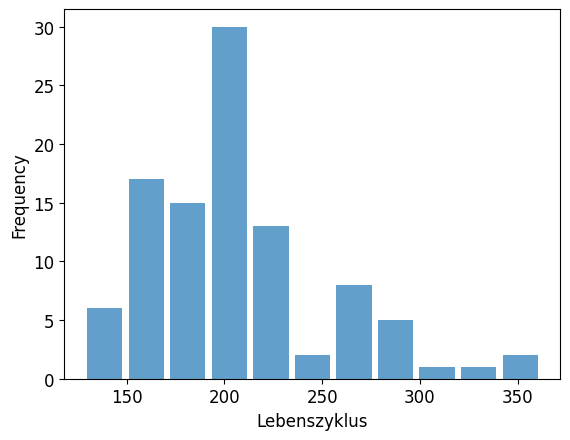

In [7]:
Zyklen_list = []
for ID in range(len(unit)):
    tmp = train_data[train_data["UnitNumber"]==ID+1]
    Zyklen_list.append(tmp.shape[0])
plt.hist(x=Zyklen_list, bins='auto',alpha=0.7, rwidth=0.85);
plt.xlabel('Lebenszyklus')
plt.ylabel('Frequency');

**Die folgende Abbildung zeigt die Zeitliche Verlauf von einem Turbofan. X Axis is the Cycle Number, Y Axis is the Sensor Value**

       Zeitliche Verlauf von Turbofan mit id 2. X Axis is the Cycle Number, Y Axis is the Sensor Value 


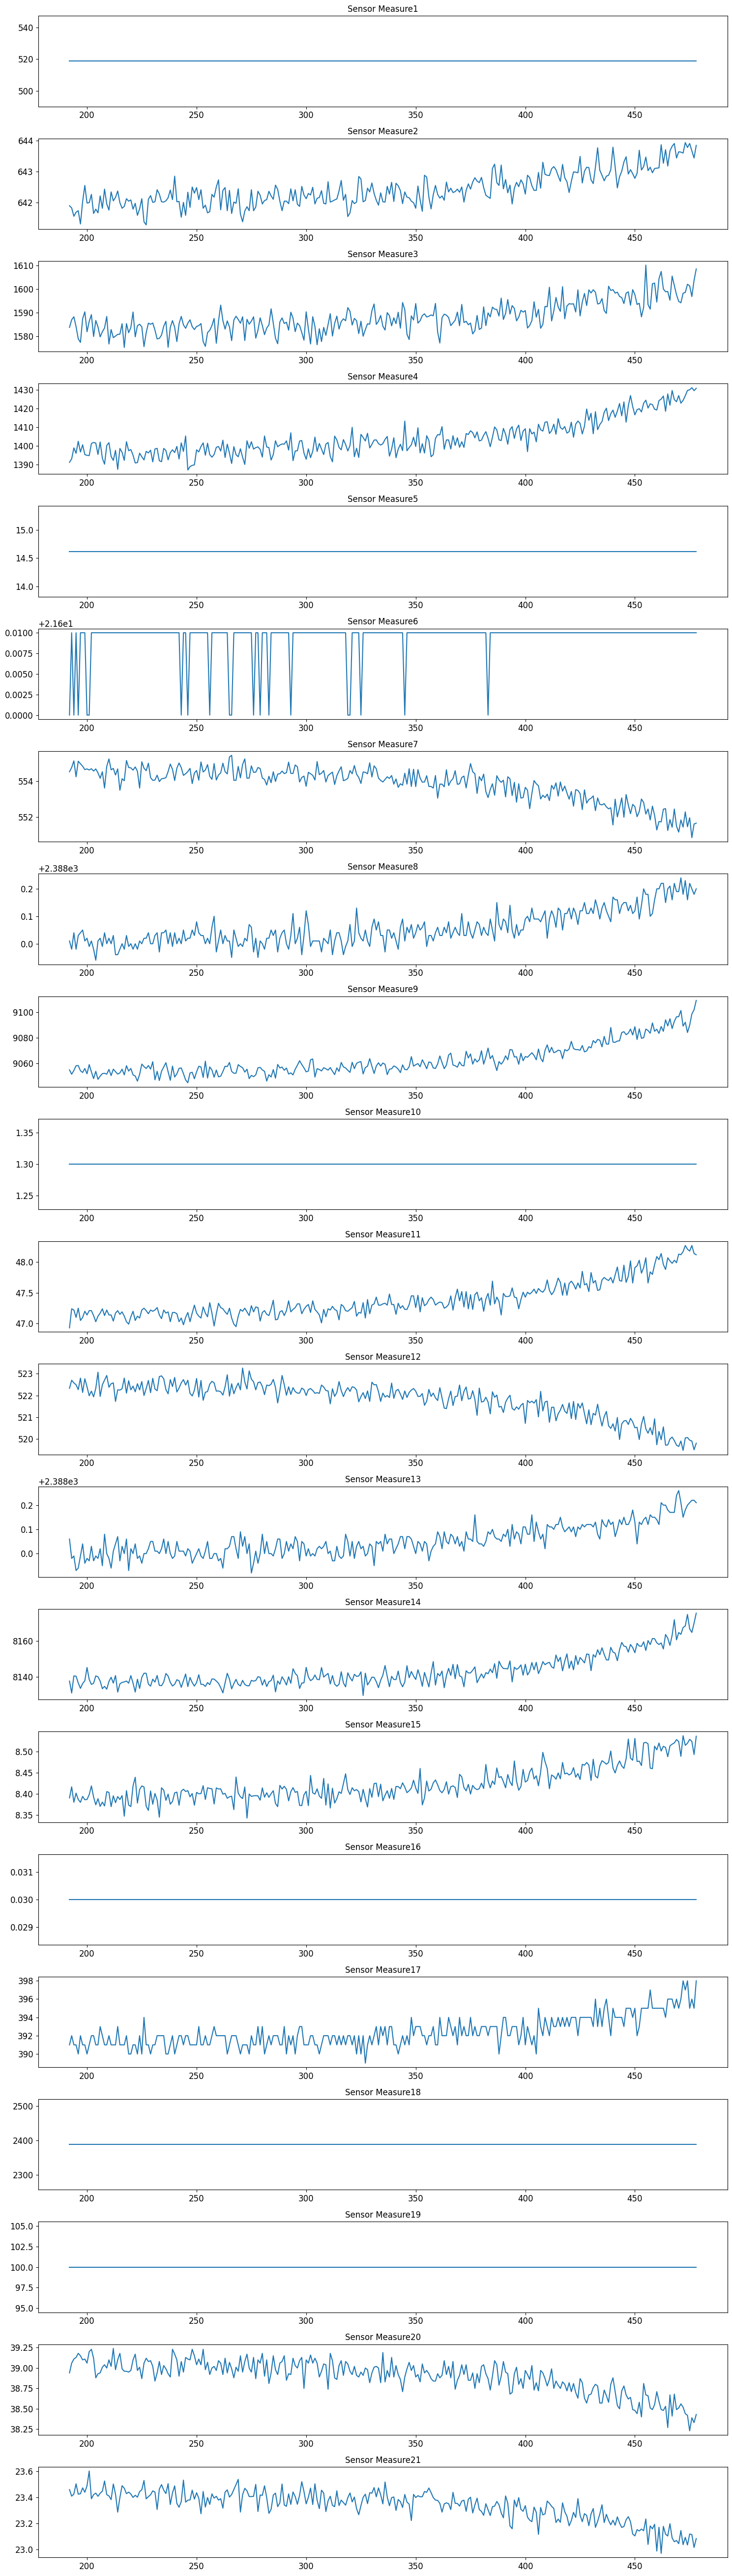

In [8]:
motor_id = 2
numberOfcolumns = len(sensor_measure_columns_names)
plt.figure(figsize=(15,2.5*len(sensor_measure_columns_names)))
Dataframe_id = train_data[train_data["UnitNumber"]==motor_id]
for i,v in enumerate(range(numberOfcolumns)):
    a = plt.subplot(numberOfcolumns,1,v+1)
    a.plot(Dataframe_id.index.values,Dataframe_id.iloc[:,v+5].values)
    a.title.set_text(sensor_measure_columns_names[v])
    plt.tight_layout()
print("       Zeitliche Verlauf von Turbofan mit id {}. X Axis is the Cycle Number, Y Axis is the Sensor Value ".format(motor_id))
plt.show()

    Der Trend der Sensorwert ist aus der obigen Abbildung deutlicher ersichtlich. Der Wert des Sensors beginnt sich ab einem bestimmten Moment zu ändern. Diese Änderungen hängen eng mit dem Zustand der Turbofan ab.

## RUL Berechnung
    Betreutes Lernen wird in der nächsten Analyse verwendet. Die Trainingsdaten enthalten jedoch keinen y-Wert (RUL). Hier lineare Degradationsmodell wird benutzt. Die Zeitschritt (Cycle) wird umgekehrt, wobei die verbleibende Zeit einer Maschine beim Ausfall 1 beträgt.

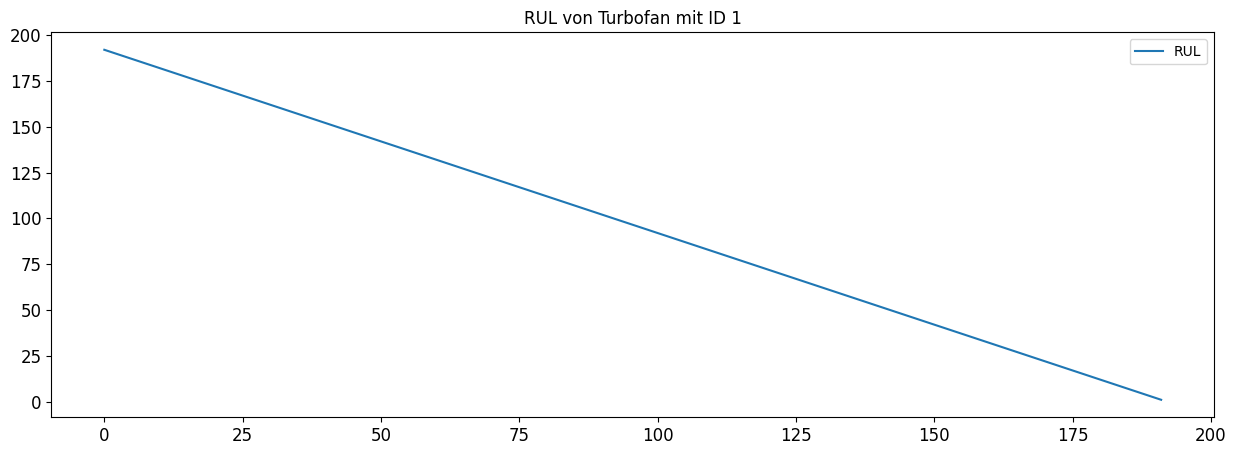

In [9]:

def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1]  
train_data['rul'] = train_data[['UnitNumber', 'Cycle']].groupby('UnitNumber').transform(f1)
plt.figure(figsize=(15,5))
motor_id = 1
df_of_id = train_data[train_data["UnitNumber"]==motor_id]
plt.plot(df_of_id.rul, label="RUL")
#plt.plot(df_of_id.Cycle, label="Cycle")
plt.legend()
plt.title("RUL von Turbofan mit ID {}".format(motor_id))
plt.show()

# Datenanalyse-Pipeline

## Merkmale Entwicklung
       Bei der Merkmale Entwicklung wird versucht, die Vorhersageleistung der Lernalgorithmen durch Erstellen von Merkmalen aus Rohdaten zu verbessern und mit diesen den Lernprozess zu vereinfachen. Die neuen Features sollen zusätzliche Informationen bereitstellen, die in den ursprünglichen oder vorhandenen Featuregruppen nicht eindeutig erfasst werden können oder nicht einfach ersichtlich sind. Doch dieser Prozess nicht einfach. Fundierte und produktive Entscheidungen erfordern häufig ein gewisses Fachwissen.
       
      Wie in der folgenden Abbildung gezeigt, verwenden wir TSFRESH, um Zeitreihen-Features aus verschiedenen Domain automatisch zu extrahieren. (https://tsfresh.readthedocs.io/en/latest/index.html)

<img src=https://www.sdsc-bw.de/image/tsfresh.png  style="width: 600px;"/>

**Sliding Window Method**

    Sliding Window Method wird verwendet um die Eingabe und Ausgabe zum Koppeln.
    
    Nehmen wir an, Sie haben eine Sensor-Zeitreihe. Nun möchten Sie ein Merkmale-basiertes Modell erstellen, um die RUL vorherzusagen. Sie müssen also in jedem Zeitschritt der ursprünglichen Zeitreihe Merkmale extrahieren, während Sie eine bestimmte Anzahl vergangener Werte betrachten. Ein Rollmechanismus (Sliding Window Method) gibt Ihnen die Unterzeitserie der letzten k Zeitschritte zum Erstellen der Merkmale (Hier k ist Window Size).

    Das folgende Bild zeigt den Vorgang. Das rote Kästchen ist die entsprechende RUL für jedes Fenster. Die Merkmale Entwicklung wird in jedem Fenster durchgeführt.

<img src=https://www.sdsc-bw.de/image/rolling.PNG  style="width: 600px;"/>



Die nachstehende Schiebefenster-Methode erweist sich als zu ineffizient. Daher wird die Ausführung des folgenden Codes sehr lange dauern. Bitte schreiben Sie Ihre eigene, effizientere Gleitfenster-Methode.

In [10]:
# Hier definieren wir die Fenstergröße mit 5
window_size = 5

engine_id = train_data["UnitNumber"].unique()
feature_x = pd.DataFrame()
RUL = pd.Series()


for index in tqdm(engine_id):

    data_frame = train_data[train_data["UnitNumber"]==index]
    add = pd.DataFrame(np.ones((1,data_frame.shape[1])), columns=data_frame.columns)
    data_frame = pd.concat([data_frame,add])
    data_frame.reset_index(inplace=True,drop=True)
    
    df_shift, _ = make_forecasting_frame(data_frame["Sensor Measure1"], kind="x", 
                                             max_timeshift = window_size, 
                                             rolling_direction=1)


    del df_shift["kind"]
    df_shift["Sensor Measure1"] = df_shift["value"]

    df_shift.reset_index(inplace=True,drop=True)
    del df_shift["value"]
    for column in sensor_measure_columns_names[1:]:

        temp, _ = make_forecasting_frame(data_frame[column], kind="x", 
                                             max_timeshift = window_size, 
                                             rolling_direction=1)
        temp.reset_index(inplace=True,drop=True)

        df_shift[column] = temp["value"]


        

        if df_shift.isna().sum().sum()>0:
            assert 1==0
    # Als Beispiel extrahieren wir nur einige grundlegende statistische Merkmale. wie MEAN MAX MIN VARIANZ
    # Sie können die Einstellungen von default_fc_parameters ändern, um die zu extrahierenden Features auszuwählen.
    All_features = extract_features(df_shift, column_id="id", column_sort="time",
                                    default_fc_parameters=MinimalFCParameters(),
                                    impute_function=None, disable_progressbar=True,
                                    show_warnings=False, n_jobs=8)
    
    All_features=All_features.iloc[window_size-1:]
    y = data_frame["rul"].iloc[window_size-1:-1]
    
    feature_x = pd.concat([feature_x, All_features])
    RUL = pd.concat([RUL, y])


Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 39.75it/s]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 38.97it/s]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 38.45it/s]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 37.45it/s]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 38.41it/s]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 38.58it/s]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 38.45it/s]

Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 37.39it/s]

Rolling: 100%|██████████████████

In [11]:
RUL.reset_index(drop=True, inplace=True)

## Merkmale Verarbeitung

**Suchen und löschen die Merkmale, die mit einem Bruchteil der fehlenden Werte über dem Schwellenwert sind.**

In [12]:
def identify_and_remove_missing(Dataframe, Threshold=0.1):
    missing_series = pd.DataFrame( Dataframe.isnull().sum() / Dataframe.shape[0]).rename(columns = {'index': 'feature', 0: 'missing_fraction'})
    record_missing  = missing_series[missing_series["missing_fraction"]>Threshold]
    to_drop = list(record_missing.index)
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe
print("Größe vor der Verarbeitung ", feature_x.shape)
feature_x = identify_and_remove_missing(feature_x)
print("Größe nach der Verarbeitung ", feature_x.shape)

Größe vor der Verarbeitung  (20231, 210)
Größe nach der Verarbeitung  (20231, 210)


In [13]:
feature_x

Sensor Measure1__sum_values  Sensor Measure1__median  \
id 5                        2593.35                   518.67   
   6                        2593.35                   518.67   
   7                        2593.35                   518.67   
   8                        2593.35                   518.67   
   9                        2593.35                   518.67   
...                             ...                      ...   
   196                      2593.35                   518.67   
   197                      2593.35                   518.67   
   198                      2593.35                   518.67   
   199                      2593.35                   518.67   
   200                      2593.35                   518.67   

        Sensor Measure1__mean  Sensor Measure1__length  \
id 5                   518.67                      5.0   
   6                   518.67                      5.0   
   7                   518.67                      5.0   
   8                   518.67                      5.0   
   9                   518.67                      5.0   
...                       ...                      ...   
   196                 518.67                      5.0   
   197                 518.67                      5.0   
   198                 518.67                      5.0   
   199                 518.67                      5.0   
   200                 518.67                      5.0   

        Sensor Measure1__standard_deviation  Sensor Measure1__variance  \
id 5                                    0.0                        0.0   
   6                                    0.0                        0.0   
   7                                    0.0                        0.0   
   8                                    0.0                        0.0   
   9                                    0.0                        0.0   
...                                     ...                        ...   
   196                                  0.0                        0.0   
   197                                  0.0                        0.0   
   198                                  0.0                        0.0   
   199                                  0.0                        0.0   
   200                                  0.0                        0.0   

        Sensor Measure1__root_mean_square  Sensor Measure1__maximum  \
id 5                               518.67                    518.67   
   6                               518.67                    518.67   
   7                               518.67                    518.67   
   8                               518.67                    518.67   
   9                               518.67                    518.67   
...                                   ...                       ...   
   196                             518.67                    518.67   
   197                             518.67                    518.67   
   198                             518.67                    518.67   
   199                             518.67                    518.67   
   200                             518.67                    518.67   

        Sensor Measure1__absolute_maximum  Sensor Measure1__minimum  \
id 5                               518.67                    518.67   
   6                               518.67                    518.67   
   7                               518.67                    518.67   
   8                               518.67                    518.67   
   9                               518.67                    518.67   
...                                   ...                       ...   
   196                             518.67                    518.67   
   197                             518.67                    518.67   
   198                             518.67                    518.67   
   199                             518.67                    518.67   
   200             

**Suchen und Löschen die Merkmale, die mit nur einem einzigen eindeutigen Wert sind. NaNs zählen nicht als eindeutiger Wert.**

In [14]:
#feature_x.nunique()==1

pd.DataFrame(feature_x.nunique()[feature_x.nunique() == 1]).reset_index()#.shape#.columns

,index,0
0,Sensor Measure1__sum_values,1
1,Sensor Measure1__median,1
2,Sensor Measure1__mean,1
3,Sensor Measure1__length,1
4,Sensor Measure1__standard_deviation,1
...,...,...
72,Sensor Measure19__maximum,1
73,Sensor Measure19__absolute_maximum,1
74,Sensor Measure19__minimum,1
75,Sensor Measure20__length,1


In [15]:
def identify_and_remove_unique_columns(Dataframe):
    unique_counts = Dataframe.nunique()
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
    to_drop = list(record_single_unique['feature'])
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe
print("Größe vor der Verarbeitung ", feature_x.shape)
feature_x = identify_and_remove_unique_columns(feature_x)
print("Größe Nach der Verarbeitung", feature_x.shape)

Größe vor der Verarbeitung  (20231, 210)
Größe Nach der Verarbeitung (20231, 133)


**Merkmaleauswahl**

    Hier wird Signifikanztest verwendet， um die korrelation zwischen extrariete Merkmale und RUL (output) zu prüfen.

In [16]:
selected_features = select_features(feature_x, RUL.values.reshape(-1))
print("Größe vor der Auswahl ", feature_x.shape)
feature_x = identify_and_remove_missing(feature_x)
print("Größe nach der Auswahl ", feature_x.shape)

Größe vor der Auswahl  (20231, 133)
Größe nach der Auswahl  (20231, 133)


**Normalisierung**

In [17]:
def feature_sigmoid_transform(Featrues_DataFrame):
    """
    transform the operations into range(0,1)
    return transformed feature Frames , the median and IQR for each feature(columns) for new feature transformation
    this is excuted only when there are tsfresh fearues
    """

    # Interquartile range for each features
    Interquartile0_25 = np.array(Featrues_DataFrame.quantile(0.25))
    Interquartile0_75 = np.array(Featrues_DataFrame.quantile(0.75))
    IQR = Interquartile0_75 - Interquartile0_25

    # Median for each features
    median = np.array(Featrues_DataFrame.median())

    feature_columns = Featrues_DataFrame.columns
    # drop the features which has fast 0.0 Interquartile
    position = np.where( IQR == 0 )[0]

    Featrues_DataFrame.drop(Featrues_DataFrame.columns[position], axis=1, inplace = True)

    median = np.delete(median,position)
    IQR = np.delete(IQR,position)

    # sigmoid transformation
    transformed_features = (1+np.exp((-Featrues_DataFrame + median)/(IQR*1.2)))**(-1)

    return median, IQR, transformed_features

median, IQR, transformed_features = feature_sigmoid_transform(selected_features)

## Regression Modelle
    Dieses Jupyter-Notebook zeigt nur den grundlegenden Prozess der vorausschauenden Wartung. Hier wurde nur ein einfaches Regression Modell gebaut. Automatisierter Analyseprozess (Modellauswahl und Hyperparameteroptimierung) wird in Jyputer Notebook mit dem Name AutoML_Turbofan_RUL.ipynb gezeigt.
    
    Neuronale Netze werden heute immer beliebter. Das neuronale Netzwerkmodell hat auch im Bereich der vorbeugenden Wartung gute Ergebnisse erzielt. Für mehr Details finden Sie in Jyputer Notebook mit dem Namen DeepConvLSTM_Turbofan_RUL.ipynb.

In [18]:
# Modellinitialisierung
model = lgb.LGBMRegressor(random_state=12)
# Model-Training
model.fit(transformed_features, RUL)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23726
[LightGBM] [Info] Number of data points in the train set: 20231, number of used features: 112
[LightGBM] [Info] Start training from score 106.909742


LGBMRegressor(random_state=12)

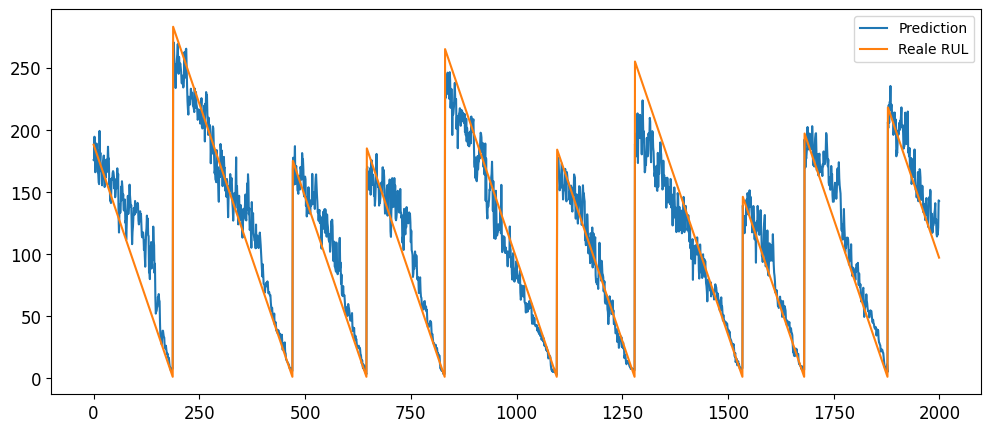

In [19]:
prediction = model.predict(transformed_features)
plt.figure(figsize=(12,5))
plt.plot((prediction[:2000]), label="Prediction")
plt.plot((RUL[:2000]), label="Reale RUL")
plt.legend()
plt.show()

    Wie aus der obigen Abbildung ersichtlich ist, ist der Trend der Maschinen Degradation lernbar, obwohl es einen Unterschied zwischen dem vorhergesagten Wert und dem wahren Wert gibt.

**Evaluationsmetrik Root Mean Square Error**

In [20]:
rms = sqrt(mean_squared_error(RUL.values.reshape(-1), prediction))
print("The RMSE auf Trainingsdaten ist :", rms)

The RMSE auf Trainingsdaten ist : 25.656519170208462


# Evaluation
    Performance auf testdaten

## Laden die Testdaten

In [21]:
print("Laden der Testdaten beginnt!")
test_data = pd.read_csv('./data/test_FD001.txt', delim_whitespace=True, header=None)
test_data.columns = input_file_column_names
print("Laden der Daten ist fertig!")
print("Größe der Daten : Rows {}, Columns {}".format(test_data.shape[0], test_data.shape[1]))
test_data.head()

Laden der Testdaten beginnt!
Laden der Daten ist fertig!
Größe der Daten : Rows 13096, Columns 26


,UnitNumber,Cycle,Operation Setting 1,Operation Setting 2,Operation Setting 3,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [22]:
# Echte RUL
RUL_FD001 = pd.read_table("./data/RUL_FD001.txt", header=None, delim_whitespace=True)

## Merkmale Berechnung

In [23]:
engine_id = test_data["UnitNumber"].unique()
window_size = 5
feature_x = pd.DataFrame()
feature_columns = transformed_features.columns

for index in tqdm(engine_id):
    data_frame = test_data[test_data["UnitNumber"]==index]
    # Hier werden nur die Informationen zur letzten Fenstergröße verwendet. 
    data_frame = data_frame.iloc[-window_size:]
    data_frame = data_frame[sensor_measure_columns_names]
    data_frame["id"] = 1
    data_frame["time"] = range(data_frame.shape[0])
    data_frame.reset_index(inplace=True,drop=True)



    All_features = extract_features(data_frame, column_id="id", column_sort="time", #column_value="value", 
                                    default_fc_parameters=MinimalFCParameters(),
                                    impute_function=None, disable_progressbar=True,
                                    show_warnings=False, n_jobs=8)

    All_features = All_features[feature_columns]
    

    feature_x = pd.concat([feature_x, All_features])
    


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


## Evaluation

In [24]:
# feature transformation
transformed_features = (1+np.exp((-feature_x + median)/(IQR*1.2)))**(-1)


prediction = model.predict(transformed_features)
prediction = np.round(prediction)

rms = sqrt(mean_squared_error(RUL_FD001.values.reshape(-1), prediction))
print("The RMSE auf Testdaten ist :", rms)

The RMSE auf Testdaten ist : 33.13049954347203


<span class="girk">**Das beste Ergebnis der aktuellen Öffentlichkeit ist ?? mit RMSE.**</span>

## Wichtige Merkmale

In [25]:
feature_names = list(transformed_features.columns)
feature_importance_values = model.feature_importances_
# Notieren die Wichtigkeiten der Merkmale
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

# Sortieren die Merkmale nach Wichtigkeit
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

# Normalisieren die Merkmale-Wichtigkeiten, um bis zu eins zu addieren
feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

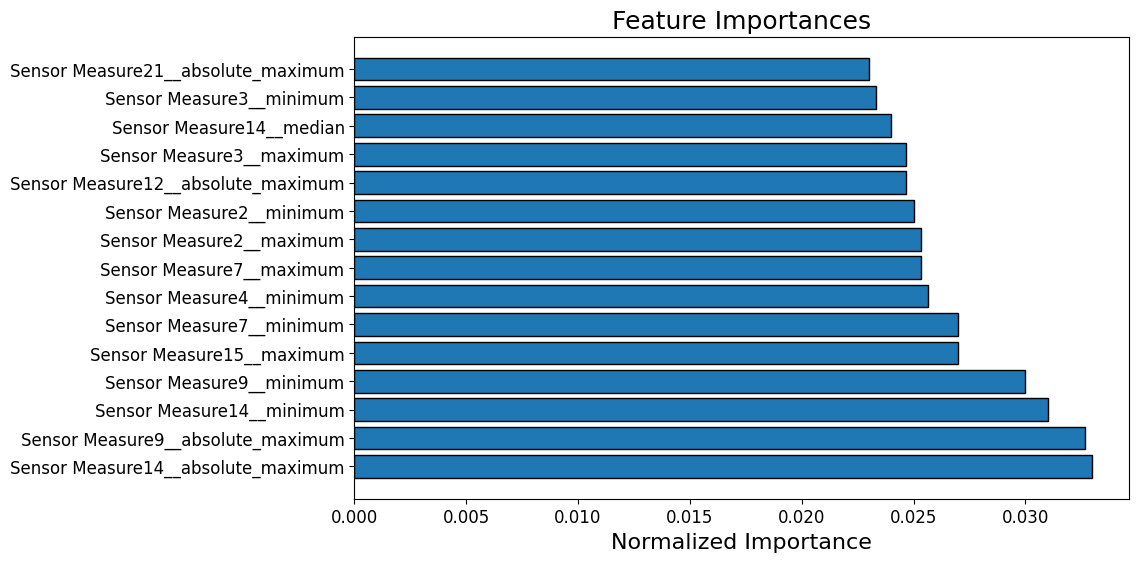

In [26]:
plot_n = 15
plt.figure(figsize = (10, 6))
ax = plt.subplot()
ax.barh(list(reversed(list(feature_importances["feature"][:plot_n]))), 
        feature_importances['normalized_importance'][:plot_n], 
        align = 'center', edgecolor = 'k')
ax.set_yticks(list(reversed(list(feature_importances["feature"][:plot_n]))))
ax.set_yticklabels(feature_importances['feature'][:plot_n], size = 12)

# Plot labeling
plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
plt.show()


1. In dieser Übung liegt der Fokus auf der Durchführung einer umfassenden explorativen Datenanalyse. Dies umfasst Methoden wie Visualisierungen und Korrelationstests, um ein tiefgreifendes Verständnis der vorliegenden Daten zu erlangen.

2. Es wird erwartet, dass Sie eine effizientere Implementierung der Sliding Window-Methode vornehmen. Diese Methode spielt eine entscheidende Rolle bei der zeitlichen Analyse von Daten.

3. Sie werden aufgefordert, die traditionelle maschinelle Lernmethodik zur Vorhersage der verbleibenden Nutzungsdauer anzuwenden. Dieser Prozess beinhaltet die Datenbereitung, Merkmalsextraktion, Merkmalsauswahl, Modellauswahl und die Optimierung von Modellparametern. Es wird erwartet, dass Sie dabei SOTA Verfahren anwenden.

4. Des Weiteren sollen Sie neuronale Netzwerkmodelle erstellen, um die verbleibende Nutzungsdauer vorherzusagen. Hierbei können verschiedene Architekturen wie Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN) oder Attention Models zum Einsatz kommen. Sie können SOTA research paper suchen und Reproduktionen aktueller State-of-the-Art-Modelle durchführen.

**Abgabe** 
Am Ende der Übung sind drei Notebooks für die oben genannten Aufgaben (1, 3 und 4) einzureichen. Diese Notebooks sollten den gesamten Prozess von der Datenanalyse über die Datenverarbeitung bis hin zum Modellaufbau, Training und Evaluierung detailliert dokumentieren. Eine gute Dokumentation ist unerlässlich und sollte sowohl die Codeerklärung als auch die Interpretation der Zwischenergebnisse umfassen.